In [1]:
import numpy as np
import sys
import gsw
import xarray as xr
import numpy as np
from scipy import integrate
from copy import deepcopy 
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cmocean
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from xgcm import Grid 
import warnings
warnings.filterwarnings('ignore')

sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco

In [2]:
# base_dir = '/home/username/'
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/v5'
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
# ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

In [3]:
## Load 2D Monthly data...SSH 
data_dir= ECCO_dir + '/nctiles_monthly'
# ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, vars_to_load=['SSHDYN','OBPNOPAB', 'RHOAnoma'], \
#                                                              years_to_load=range(2011,2018)).load() # ,'PHIHYD','RHOAnoma','SALT','UVEL','VVEL'    
ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, \
                                           vars_to_load=['ETAN', 'PHIBOT'],\
                                           years_to_load=range(2013,2018)).load()    
## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_monthly_ds = xr.merge((ecco_grid , ecco_daily_vars))

loading files of  ETAN
loading files of  PHIBOT


In [4]:
ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)

In [5]:
# LLC90
# load steric height and steric pressure already computed 
ds_den0 = '/Users/jakesteinberg/Documents/NASA_OSTST/rho_steric_2011_2017.nc'
ds_den = xr.open_dataset(ds_den0)

In [6]:
# LLC270
# load steric height and steric pressure already computed 
ds_den0 = '/Users/jakesteinberg/Documents/NASA_OSTST/rho_270_steric_2013.nc'
ds_den1 = '/Users/jakesteinberg/Documents/NASA_OSTST/rho_270_steric_2014.nc'
ds_den2 = '/Users/jakesteinberg/Documents/NASA_OSTST/rho_270_steric_2015.nc'
ds_den3 = '/Users/jakesteinberg/Documents/NASA_OSTST/rho_270_steric_2016.nc'
ds_den4 = '/Users/jakesteinberg/Documents/NASA_OSTST/rho_270_steric_2017.nc'
ds_den01 = xr.open_dataset(ds_den0)
ds_den11 = xr.open_dataset(ds_den1)
ds_den21 = xr.open_dataset(ds_den2)
ds_den31 = xr.open_dataset(ds_den3)
ds_den41 = xr.open_dataset(ds_den4)

In [7]:
metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
}
# XC distance from grid center point to center point 
# XG distance from grid egde (where u is defined) to grid edge (finite difference of values at XC will be placed here)
grid = Grid(ecco_monthly_ds, metrics=metrics)

In [8]:
tile_num=10
lon_range = [-108, -40] # [-128,-40]
lat_range = [15, 40] # [15, 50]
# lon_range = [-39, 0]
# lat_range = [20, 60]
# -- pull out lats and lons
lons = ecco_monthly_ds.XC.sel(tile=tile_num)
lats = ecco_monthly_ds.YC.sel(tile=tile_num)
lons_g = ecco_monthly_ds.XG.sel(tile=tile_num)
lats_g = ecco_monthly_ds.YG.sel(tile=tile_num)

In [9]:
# bathymetry
dep = ecco_monthly_ds.Depth
dep = dep.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
testx = grid.diff(dep,axis='X')/(ecco_monthly_ds.dxG.data/1000)
testy = grid.diff(dep,axis='Y')/(ecco_monthly_ds.dyG.data/1000)
H_x = grid.interp(testx,'X')
H_y = grid.interp(testy,'Y')
gradH_np = np.sqrt(H_x.isel(tile=tile_num).data**2 + H_y.isel(tile=tile_num).data**2)
gradH = xr.DataArray(
    data=gradH_np, dims=["j", "i"],
    coords=dict(
        i=(["i"], np.arange(np.shape(lons)[1])), j=(["j"], np.arange(np.shape(lons)[0])),
    ),
)

In [128]:
# !! -- LLC270 -- 
g = 9.81 
rho0 = 1035
# -- SLA --  
ssh_anom = ecco_monthly_ds.ETAN-ecco_monthly_ds.ETAN.mean(dim='time')
pssh = ssh_anom.polyfit(dim='time', deg=1)
ssh_a_trend = xr.polyval(ssh_anom['time'], pssh.polyfit_coefficients)
ssh_a_detrend = ssh_anom - ssh_a_trend
s_press = rho0*g*(ssh_a_detrend)
s_press = s_press.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
# -- OBP --  
obp_cor = 1029*(ecco_monthly_ds.PHIBOT + g*dep)
obp_anom = obp_cor-obp_cor.mean(dim='time')
pobp = obp_anom.polyfit(dim='time', deg=1)
obp_a_trend = xr.polyval(obp_anom['time'], pobp.polyfit_coefficients)
obp_a_detrend = obp_anom - obp_a_trend
obp = (obp_a_detrend)
obp = obp.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
# -- Steric Height -- 
ds_den = xr.concat([ds_den01.steric_p, ds_den11.steric_p, ds_den21.steric_p, ds_den31.steric_p, ds_den41.steric_p], dim="time")
ster_a = 1*(ds_den-ds_den.mean(dim='time'))
pster = ster_a.polyfit(dim='time', deg=1)
ster_a_trend = xr.polyval(ster_a['time'], pster.polyfit_coefficients)
ster_a_detrend = ster_a - ster_a_trend
ster = ster_a_detrend.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
# -- density anomalies (my estimate) -- 
ds_den_r = xr.concat([ds_den01.rho, ds_den11.rho, ds_den21.rho, ds_den31.rho, ds_den41.rho], dim="time")
rho_a = ds_den_r - ds_den_r.mean(dim='time')
p = rho_a.polyfit(dim='time', deg=1)
rho_a_trend = xr.polyval(rho_a['time'], p.polyfit_coefficients)
rho_a_detrend = rho_a - rho_a_trend
rho = rho_a_detrend.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

In [129]:
# !! -- LLC270 -- 
# -- derivatives 
# - sea surface height 
basex_eta = grid.diff(s_press,axis='X')/(ecco_monthly_ds.dxG.data/1000)
basey_eta = grid.diff(s_press,axis='Y')/(ecco_monthly_ds.dyG.data/1000)
deta_dx = grid.interp(basex_eta,'X')
deta_dy = grid.interp(basey_eta,'Y')
# - OBP 
basex_obp = grid.diff(obp,axis='X')/(ecco_monthly_ds.dxG.data/1000)
basey_obp = grid.diff(obp,axis='Y')/(ecco_monthly_ds.dyG.data/1000)
dobp_dx = grid.interp(basex_obp,'X')
dobp_dy = grid.interp(basey_obp,'Y')
# - steric height
basex = grid.diff(ster,axis='X')/(ecco_monthly_ds.dxG.isel(tile=tile_num).data/1000)
basey = grid.diff(ster,axis='Y')/(ecco_monthly_ds.dyG.isel(tile=tile_num).data/1000)
dster_dx = grid.interp(basex,'X')
dster_dy = grid.interp(basey,'Y')
# - find bottom layer index
test = np.ceil(ecco_grid.hFacC.sum(dim='k')).isel(tile=tile_num) - 1 # remember index is off by one from layer numbers # np.floor(ecco_grid.hFacC.sum(dim='k')).isel(tile=tile_num)
# - bottom density*g*bathymetric gradient 
topox = (rho.isel(layer=test.astype(int)))*g*H_x.isel(tile=tile_num) # - rho.isel(layer=test.astype(int)).mean(dim='time')
topoy = (rho.isel(layer=test.astype(int)))*g*H_y.isel(tile=tile_num)
# -- alternate statement on approx D  
# rho_tot = ds_den.rho.isel(tile=tile_num)
# p_tot = rho_tot*g*(-1*zz) # in pascal ... to get to decibar, /10000
# p_tot_a = p_tot - p_tot.mean(dim='time')
layer_thickness = ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF
lt1 = layer_thickness.where(layer_thickness != 0, np.nan)
zz = -1*(lt1.cumsum(dim='k') - 0.5*lt1)
layer_thickness = layer_thickness.rename({'k': 'layer'})
zz = zz.rename({'k': 'layer'})
H = (ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF).sum(dim='k')
H = H.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
E = (g*(1)*zz*rho*layer_thickness).sum(dim='layer')
E = E.transpose('time', 'j', 'i')
basex_E = grid.diff(E,axis='X')/(ecco_monthly_ds.dxG.isel(tile=tile_num).data/1000)
basey_E = grid.diff(E,axis='Y')/(ecco_monthly_ds.dyG.isel(tile=tile_num).data/1000)
dE_dx = grid.interp(basex_E,'X')
dE_dy = grid.interp(basey_E,'Y')
dpb_dx = dE_dx.where(dE_dx !=0, np.nan)
dpb_dy = dE_dy.where(dE_dx !=0, np.nan)
dpb_dx = (-1/H)*dpb_dx
dpb_dy = (-1/H)*dpb_dy
# variance metrics 
deta_dx2 = (deta_dx.isel(tile=tile_num)).var(dim='time')
deta_dy2 = (deta_dy.isel(tile=tile_num)).var(dim='time')
K_eta = np.sqrt(0.5*(deta_dx2 + deta_dy2))
dobp_dx2 = (dobp_dx.isel(tile=tile_num)).var(dim='time')
dobp_dy2 = (dobp_dy.isel(tile=tile_num)).var(dim='time')
K_obp = np.sqrt(0.5*(dobp_dx2 + dobp_dy2))
dster_dx2 = (dster_dx).var(dim='time')
dster_dy2 = (dster_dy).var(dim='time')
K_ster = np.sqrt(0.5*(dster_dx2 + dster_dy2))
dtopo_dx2 = (topox).var(dim='time')
dtopo_dy2 = (topoy).var(dim='time')
K_topo = np.sqrt(0.5*(dtopo_dx2 + dtopo_dy2))
dD_dx2 = (dpb_dx).var(dim='time')
dD_dy2 = (dpb_dy).var(dim='time')
K_D = np.sqrt(0.5*(dD_dx2 + dD_dy2))

In [13]:
g = 9.81; rho0 = 1035;
# -- bring in fields and remove time mean and linear trend (and set land values to 0)
# --- SLA --  
ssh_anom = ecco_monthly_ds.SSHDYN-ecco_monthly_ds.SSHDYN.mean(dim='time')
pssh = ssh_anom.polyfit(dim='time', deg=1)
ssh_a_trend = xr.polyval(ssh_anom['time'], pssh.polyfit_coefficients)
ssh_a_detrend = ssh_anom - ssh_a_trend
s_press = rho0*g*(ssh_a_detrend)
s_press = s_press.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
# --- OBP -- 
obp_anom = ecco_monthly_ds.OBPNOPAB-ecco_monthly_ds.OBPNOPAB.mean(dim='time')
pobp = obp_anom.polyfit(dim='time', deg=1)
obp_a_trend = xr.polyval(obp_anom['time'], pobp.polyfit_coefficients)
obp_a_detrend = obp_anom - obp_a_trend
obp = rho0*g*(obp_a_detrend)
obp = obp.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
# --- Steric Height -- 
ster_a = 1*(ds_den.steric_p-ds_den.steric_p.mean(dim='time'))
pster = ster_a.polyfit(dim='time', deg=1)
ster_a_trend = xr.polyval(ster_a['time'], pster.polyfit_coefficients)
ster_a_detrend = ster_a - ster_a_trend
ster_a_detrend = ster_a_detrend.isel(tile=tile_num)
ster = ster_a_detrend.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
# --- density anomalies (my estimate) -- 
rho_a = ds_den.rho.isel(tile=tile_num) - ds_den.rho.isel(tile=tile_num).mean(dim='time')
p = rho_a.polyfit(dim='time', deg=1)
rho_a_trend = xr.polyval(rho_a['time'], p.polyfit_coefficients)
rho_a_detrend = rho_a - rho_a_trend
rho = rho_a_detrend.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
# --- density anomalies (RHOAnoma) -- 
rho_0 = ecco_monthly_ds.RHOAnoma.isel(tile=tile_num)
rho_0 = rho_0.where(ecco_monthly_ds.hFacC.isel(tile=tile_num) !=0, np.nan)
rho_a_2 = rho_0 - rho_0.mean(dim='time')
p_2 = rho_a_2.polyfit(dim='time', deg=1)
rho_a_2_trend = xr.polyval(rho_a_2['time'], p_2.polyfit_coefficients)
rho_a_2_detrend = rho_a_2 - rho_a_2_trend
rho_2 = rho_a_2_detrend
# -- PRESSURE 
# p_hyd = rho0*ecco_monthly_ds.PHIHYD.isel(tile=tile_num) #p/rhoConst
# p_hyd = p_hyd.where(ecco_monthly_ds.hFacC.isel(tile=tile_num) !=0, np.nan)
# p_a = p_hyd - p_hyd.mean(dim='time')
# p_p = p_a.polyfit(dim='time', deg=1)
# p_a_trend = xr.polyval(p_a['time'], p_p.polyfit_coefficients)
# p_a_detrend = p_a - p_a_trend
# p_h = p_a_detrend.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

In [12]:
# AVISO SLA 
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_obs_ssh_allsat_l4_pt25deg_P1D_1644446947552_2011_2017.nc'
av = xr.open_dataset(av_path)
av_time_o = np.where((av.time > ecco_monthly_ds.time[0]) & (av.time < ecco_monthly_ds.time[-1]))[0]
avsla = av.sla[av_time_o,:,:]
avsla = avsla-avsla.mean(dim='time')
pavsla = avsla.polyfit(dim='time', deg=1)
avsla_trend = xr.polyval(avsla['time'], pavsla.polyfit_coefficients)
avsla_detrend = avsla - avsla_trend

In [374]:
# depth average flow 
H = (ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF).sum(dim='k')
H = H.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
layer_thickness = ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF
u0 = ecco_monthly_ds.UVEL.isel(tile=tile_num)
v0 = ecco_monthly_ds.VVEL.isel(tile=tile_num)
u1 = grid.interp(u0,'X')
v1 = grid.interp(v0,'Y')
u2 = (u1*layer_thickness).sum(dim='k')
v2 = (v1*layer_thickness).sum(dim='k')
u3 = u2.where(u2 !=0, np.nan)
v3 = v2.where(v2 !=0, np.nan)
u_da = (1/H)*u3
v_da = (1/H)*v3
uvar = (u_da).var(dim='time')
vvar = (v_da).var(dim='time')
K_uv = np.sqrt(0.5*(uvar + vvar))
KE_BT = (0.5)*((u_da**2*layer_thickness).sum(dim='k') + (v_da**2*layer_thickness).sum(dim='k'))
KE_BC = (0.5)*(((u1-u_da)**2*layer_thickness).sum(dim='k') + ((v1-v_da)**2*layer_thickness).sum(dim='k'))
BC_BT_mean = (KE_BC/KE_BT).mean(dim='time')
BC_BT_var = (KE_BC/KE_BT).var(dim='time')

In [14]:
# -- derivatives 
# - sea surface height 
basex_eta = grid.diff(s_press,axis='X')/(ecco_monthly_ds.dxG.data/1000)
basey_eta = grid.diff(s_press,axis='Y')/(ecco_monthly_ds.dyG.data/1000)
deta_dx = grid.interp(basex_eta,'X')
deta_dy = grid.interp(basey_eta,'Y')

# - ocean bottom pressure
basex = grid.diff(obp,axis='X')/(ecco_monthly_ds.dxG.data/1000)
basey = grid.diff(obp,axis='Y')/(ecco_monthly_ds.dyG.data/1000)
dobp_dx = grid.interp(basex,'X')
dobp_dy = grid.interp(basey,'Y')

# - steric height
basex = grid.diff(ster,axis='X')/(ecco_monthly_ds.dxG.isel(tile=tile_num).data/1000)
basey = grid.diff(ster,axis='Y')/(ecco_monthly_ds.dyG.isel(tile=tile_num).data/1000)
dster_dx = grid.interp(basex,'X')
dster_dy = grid.interp(basey,'Y')

# - density 
basex_rho = grid.diff(rho,axis='X')/(ecco_monthly_ds.dxG.isel(tile=tile_num).data/1000)
basey_rho = grid.diff(rho,axis='Y')/(ecco_monthly_ds.dyG.isel(tile=tile_num).data/1000)
drho_dx = grid.interp(basex_rho,'X')
drho_dy = grid.interp(basey_rho,'Y')

# -- approx D (vertical integral of g*z*drho_dx,g*z*drho_dy)
layer_thickness = ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF
# WRONG zz = layer_thickness.Z
# WRONG zz = zz.where(layer_thickness != 0, np.nan)
lt1 = layer_thickness.where(layer_thickness != 0, np.nan)
zz = -1*(lt1.cumsum(dim='k') - 0.5*lt1)
# layer_thickness = ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF
layer_thickness = layer_thickness.rename({'k': 'layer'})
# layer_thickness = layer_thickness.where(layer_thickness != 0, np.nan)
zz = zz.rename({'k': 'layer'})

H = (ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF).sum(dim='k')
H = H.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
a_D_x0 = (g*zz*drho_dx*layer_thickness).sum(dim='layer')
a_D_y0 = (g*zz*drho_dy*layer_thickness).sum(dim='layer')
a_D_x0 = a_D_x0.where(a_D_x0 !=0, np.nan)
a_D_y0 = a_D_y0.where(a_D_y0 !=0, np.nan)
a_D_x = (-1/H)*a_D_x0
a_D_y = (-1/H)*a_D_y0

# -- alternate statement on approx D  
rho_tot = ds_den.rho.isel(tile=tile_num)
p_tot = rho_tot*g*(-1*zz) # in pascal ... to get to decibar, /10000
p_tot_a = p_tot - p_tot.mean(dim='time')
E = (g*(1)*zz*rho*layer_thickness).sum(dim='layer')
E = E.transpose('time', 'j', 'i')
basex_E = grid.diff(E,axis='X')/(ecco_monthly_ds.dxG.isel(tile=tile_num).data/1000)
basey_E = grid.diff(E,axis='Y')/(ecco_monthly_ds.dyG.isel(tile=tile_num).data/1000)
dE_dx = grid.interp(basex_E,'X')
dE_dy = grid.interp(basey_E,'Y')
dpb_dx = dE_dx.where(dE_dx !=0, np.nan)
dpb_dy = dE_dy.where(dE_dx !=0, np.nan)
dpb_dx = (-1/H)*dpb_dx
dpb_dy = (-1/H)*dpb_dy

# - find bottom layer index
test = np.ceil(ecco_grid.hFacC.sum(dim='k')).isel(tile=tile_num) - 1 # remember index is off by one from layer numbers # np.floor(ecco_grid.hFacC.sum(dim='k')).isel(tile=tile_num)
# - bottom density*g*bathymetric gradient 
topox = (rho.isel(layer=test.astype(int)))*g*H_x.isel(tile=tile_num) # - rho.isel(layer=test.astype(int)).mean(dim='time')
topoy = (rho.isel(layer=test.astype(int)))*g*H_y.isel(tile=tile_num)

# ---- A Check on Assumption D --- 
# - depth average horizontal pressure gradient 
layer_thickness = ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF
# layer_thickness = layer_thickness.where(layer_thickness != 0, np.nan)
basex_p = grid.diff(p_h,axis='X')/(ecco_monthly_ds.dxG.isel(tile=tile_num).data/1000)
basey_p = grid.diff(p_h,axis='Y')/(ecco_monthly_ds.dyG.isel(tile=tile_num).data/1000)
dp_dx = grid.interp(basex_p,'X')
dp_dy = grid.interp(basey_p,'Y')
dahpg_x = (dp_dx*layer_thickness).sum(dim='k')
dahpg_y = (dp_dy*layer_thickness).sum(dim='k')
dahpg_x = dahpg_x.where(dahpg_x !=0, np.nan)
dahpg_y = dahpg_y.where(dahpg_y !=0, np.nan)
dahpg_x = (1/H)*dahpg_x
dahpg_y = (1/H)*dahpg_y
# - gradient of depth integrated pressure (w/ bottom boundary correction)
layer_thickness = layer_thickness.rename({'k': 'layer'})
dap = (p_tot_a*layer_thickness).sum(dim='layer')
dap = dap.where(dap !=0, np.nan)
hpg_dap_x = grid.diff(dap,axis='X')/(ecco_monthly_ds.dxG.isel(tile=tile_num).data/1000)
hpg_dap_y = grid.diff(dap,axis='Y')/(ecco_monthly_ds.dxG.isel(tile=tile_num).data/1000)
dp_dx = grid.interp(hpg_dap_x,'X') + p_tot_a.isel(layer=test.astype(int))*H_x.isel(tile=tile_num)
dp_dy = grid.interp(hpg_dap_y,'Y') + p_tot_a.isel(layer=test.astype(int))*H_y.isel(tile=tile_num) 
hpg_dap_x = (1/H)*dp_dx
hpg_dap_y = (1/H)*dp_dy

In [210]:
lt2 = layer_thickness[:,lon_test,lat_test].copy()
dig =(-g*zz[:,lon_test,lat_test]).cumsum(dim='layer')
tpc = (((p_hyd[0,:,lon_test,lat_test].data/rho0)+dig)*rho0)/10000

In [643]:
print(ecco_grid.drF.data)
print(layer_thickness[:,lon_test,lat_test].data)
lt1 = layer_thickness.where(layer_thickness != 0, np.nan)
lt2 = -1*(lt1.cumsum(dim='k') - 0.5*lt1)
# zz1 = layer_thickness.diff(dim='k')
print(lt1[:,lon_test,lat_test].data)
print(lt2[:,lon_test,lat_test].data)
print(lt2[:,lon_test,lat_test].data - layer_thickness.Z.data)
layer_thickness.Z.data

[ 10.    10.    10.    10.    10.    10.    10.    10.01  10.03  10.11
  10.32  10.8   11.76  13.42  16.04  19.82  24.85  31.1   38.42  46.5
  55.    63.5   71.58  78.9   85.15  90.18  93.96  96.58  98.25  99.25
 100.01 101.33 104.56 111.33 122.83 139.09 158.94 180.83 203.55 226.5
 249.5  272.5  295.5  318.5  341.5  364.5  387.5  410.5  433.5  456.5 ]
[ 10.      10.      10.      10.      10.      10.      10.      10.01
  10.03    10.11    10.32    10.8     11.76    13.42    16.04    19.82
  24.85    31.1     38.42    46.5     55.      63.5     71.58    78.9
  85.15    90.18    93.96    96.58    98.25    99.25   100.01   101.33
 104.56   111.33   122.83   139.09   158.94   180.83   203.55   226.5
 249.5    272.5    128.1477   0.       0.       0.       0.       0.
   0.       0.    ]
[ 10.      10.      10.      10.      10.      10.      10.      10.01
  10.03    10.11    10.32    10.8     11.76    13.42    16.04    19.82
  24.85    31.1     38.42    46.5     55.      63.5     71.58 

array([-5.000000e+00, -1.500000e+01, -2.500000e+01, -3.500000e+01,
       -4.500000e+01, -5.500000e+01, -6.500000e+01, -7.500500e+01,
       -8.502500e+01, -9.509500e+01, -1.053100e+02, -1.158700e+02,
       -1.271500e+02, -1.397400e+02, -1.544700e+02, -1.724000e+02,
       -1.947350e+02, -2.227100e+02, -2.574700e+02, -2.999300e+02,
       -3.506800e+02, -4.099300e+02, -4.774700e+02, -5.527100e+02,
       -6.347350e+02, -7.224000e+02, -8.144700e+02, -9.097400e+02,
       -1.007155e+03, -1.105905e+03, -1.205535e+03, -1.306205e+03,
       -1.409150e+03, -1.517095e+03, -1.634175e+03, -1.765135e+03,
       -1.914150e+03, -2.084035e+03, -2.276225e+03, -2.491250e+03,
       -2.729250e+03, -2.990250e+03, -3.274250e+03, -3.581250e+03,
       -3.911250e+03, -4.264250e+03, -4.640250e+03, -5.039250e+03,
       -5.461250e+03, -5.906250e+03], dtype=float32)

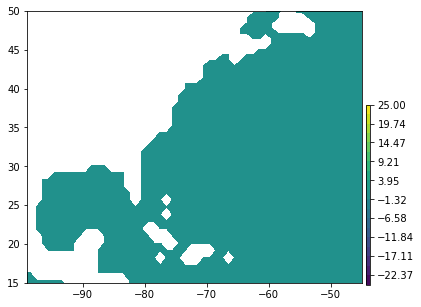

In [651]:
# te = ecco_grid.hFacC.isel(tile=tile_num)
test = np.ceil(ecco_grid.hFacC.sum(dim='k')).isel(tile=tile_num) - 1
f, (ax1) = plt.subplots(1,1,figsize=(6,5))
# tile_to_plot = p_tot.isel(layer=test.astype(int))[0] # .isel(k=test.astype(int))

# tile_to_plot = zz.isel(layer=test.astype(int)) + 0.5*te.isel(k=test.astype(int))*layer_thickness.isel(k=test.astype(int))# .isel(k=test.astype(int))
tile_to_plot = dep.isel(tile=tile_num) - (np.abs(zz.isel(layer=test.astype(int))) + 0.5*layer_thickness.isel(layer=test.astype(int)))
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
Kc = ax1.contourf(lons, lats, tile_to_plot, np.linspace(-25, 25, 20,endpoint=True), vmin=-25, vmax=25)
ax1.set_xlim(lon_range); ax1.set_ylim(lat_range);
cbpos = [0.91, 0.12, 0.01, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both')

Text(0.5, 1.0, 'bottom density anomalies')

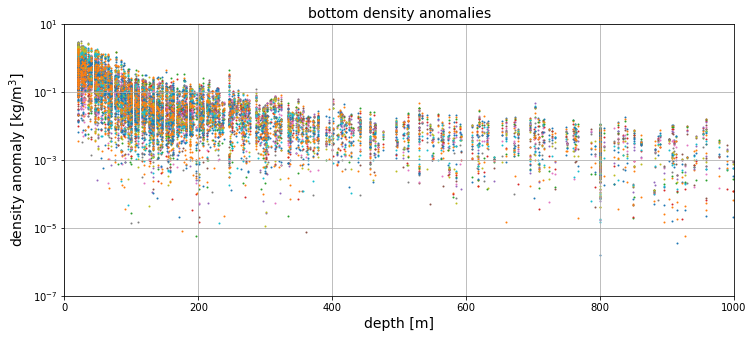

In [16]:
test = np.ceil(ecco_grid.hFacC.sum(dim='k')).isel(tile=tile_num) - 1 # remember index is off by one from layer numbers # np.floor(ecco_grid.hFacC.sum(dim='k')).isel(tile=tile_num)
# np.shape((rho.isel(layer=test.astype(int))))
f, ax = plt.subplots(1,1,figsize=(12,5))
for i in range(12):
    ax.scatter(dep.isel(tile=tile_num),np.abs(rho.isel(layer=test.astype(int))[i,:,:]), s=1)
ax.grid(); ax.set_yscale('log'); ax.set_ylim([10e-8, 10]); ax.set_xlim([0,1000]);
ax.set_xlabel('depth [m]', fontsize=14); ax.set_ylabel(r'density anomaly [kg/m$^3$]', fontsize=14); 
ax.set_title('bottom density anomalies', fontsize=14)
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_01_20/tile13_rho_prime.jpg', dpi=250)

In [17]:
# variance metrics 
deta_dx2 = (deta_dx.isel(tile=tile_num)).var(dim='time')
deta_dy2 = (deta_dy.isel(tile=tile_num)).var(dim='time')
K_eta = np.sqrt(0.5*(deta_dx2 + deta_dy2))
dster_dx2 = (dster_dx).var(dim='time')
dster_dy2 = (dster_dy).var(dim='time')
K_ster = np.sqrt(0.5*(dster_dx2 + dster_dy2))
dobp_dx2 = (dobp_dx.isel(tile=tile_num)).var(dim='time')
dobp_dy2 = (dobp_dy.isel(tile=tile_num)).var(dim='time')
K_obp = np.sqrt(0.5*(dobp_dx2 + dobp_dy2))
dtopo_dx2 = (topox).var(dim='time')
dtopo_dy2 = (topoy).var(dim='time')
K_topo = np.sqrt(0.5*(dtopo_dx2 + dtopo_dy2))
dD_dx2 = (dpb_dx).var(dim='time')
dD_dy2 = (dpb_dy).var(dim='time')
K_D = np.sqrt(0.5*(dD_dx2 + dD_dy2))
dp_dx2 = (dahpg_x).var(dim='time')
dp_dy2 = (dahpg_y).var(dim='time')
K_dahpg = np.sqrt(0.5*(dp_dx2 + dp_dy2))
dp_dx2 = (hpg_dap_x).var(dim='time')
dp_dy2 = (hpg_dap_y).var(dim='time')
K_hpg_dap = np.sqrt(0.5*(dp_dx2 + dp_dy2))
# depth average horizontal pressure gradient test 
dtx = (deta_dx.isel(tile=tile_num) - dster_dx - dpb_dx).var(dim='time')
dty = (deta_dy.isel(tile=tile_num) - dster_dy - dpb_dy).var(dim='time')
K_dap = np.sqrt(0.5*(dtx + dty))

In [85]:
# plotting of model grid points
ocx = ecco_monthly_ds.XC.isel(tile=tile_num).copy()
ocy = ecco_monthly_ds.YC.isel(tile=tile_num).copy()
ocx = ocx.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
ocy = ocy.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

(25.488489151000977, 31.565523147583008)

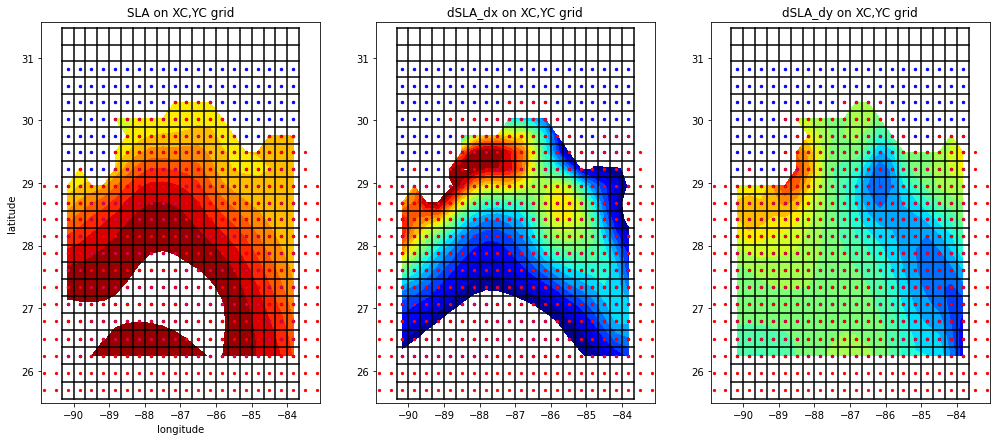

In [89]:
lon_w = -92
lon_e = -84
lat_s = 26
lat_n = 31
tglon = np.where((lons[:,0] > lon_w) & (lons[:,0] < lon_e))[0]
tglat = np.where((lats[0,:] > lat_s) & (lats[0,:] < lat_n))[0]
tglon_g = np.where((lons_g[:,0] >= (lon_w-.5)) & (lons_g[:,0] <= (lon_e+0.5)))[0]
tglat_g = np.where((lats_g[0,:] >= (lat_s-.5)) & (lats_g[0,:] <= (lat_n+0.5)))[0]
# print(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0)[tglon,tglat].data.T)
# print(lons[tglon,tglat].data.T)
# print(lats[tglon,tglat].data.T)
# print(s_press.isel(tile=tile_num)[1,tglon,tglat].data.T)
# print(deta_dx.isel(tile=tile_num)[1,tglon,tglat].data.T)
# print(deta_dy.isel(tile=tile_num)[1,tglon,tglat].data.T)

f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(17,7))
# Kc = ax1.pcolor(lons[tglon,tglat], lats[tglon,tglat], s_press.isel(tile=tile_num)[1,tglon,tglat], cmap='jet', vmin=-2000, vmax=-1000)
Kc = ax1.contourf(lons[tglon,tglat], lats[tglon,tglat], s_press.isel(tile=tile_num)[1,tglon,tglat], np.linspace(-2000,-500, 20,endpoint=True), cmap='jet', vmin=-2000, vmax=-500)
ax1.scatter(lons[tglon,tglat], lats[tglon,tglat], s=6, color='b')
ax1.scatter(ocx, ocy, s=5, color='r')
ax1.plot(ecco_monthly_ds.XG.isel(tile=tile_num)[tglon_g,tglat_g], ecco_monthly_ds.YG.isel(tile=tile_num)[tglon_g,tglat_g],'k-')
ax1.plot(ecco_monthly_ds.XG.isel(tile=tile_num)[tglon_g,tglat_g].T, ecco_monthly_ds.YG.isel(tile=tile_num)[tglon_g,tglat_g].T,'k-')
ax1.set_title('SLA on XC,YC grid')
ax1.set_xlim([np.nanmin(lons[tglon,tglat])-.75, np.nanmax(lons[tglon,tglat])+.75])
ax1.set_ylim([np.nanmin(lats[tglon,tglat])-.75, np.nanmax(lats[tglon,tglat])+.75])
ax1.set_xlabel('longitude')
ax1.set_ylabel('latitude')

Kc = ax2.contourf(lons[tglon,tglat], lats[tglon,tglat], deta_dx.isel(tile=tile_num)[1,tglon,tglat], np.linspace(0,4,20,endpoint=True), cmap='jet', vmin=0, vmax=4)
# Kc = ax2.contourf(lons[tglon,tglat], lats[tglon,tglat], test3[tglon,tglat,1], np.linspace(0,6, 20,endpoint=True), cmap='jet', vmin=0, vmax=6)
ax2.scatter(lons[tglon,tglat], lats[tglon,tglat], s=6, color='b')
ax2.scatter(ocx, ocy, s=5, color='r')
ax2.plot(ecco_monthly_ds.XG.isel(tile=tile_num)[tglon_g,tglat_g], ecco_monthly_ds.YG.isel(tile=tile_num)[tglon_g,tglat_g],'k-')
ax2.plot(ecco_monthly_ds.XG.isel(tile=tile_num)[tglon_g,tglat_g].T, ecco_monthly_ds.YG.isel(tile=tile_num)[tglon_g,tglat_g].T,'k-')
ax2.set_title('dSLA_dx on XC,YC grid')
ax2.set_xlim([np.nanmin(lons[tglon,tglat])-.75, np.nanmax(lons[tglon,tglat])+.75])
ax2.set_ylim([np.nanmin(lats[tglon,tglat])-.75, np.nanmax(lats[tglon,tglat])+.75])

Kc = ax3.contourf(lons[tglon,tglat], lats[tglon,tglat], deta_dy.isel(tile=tile_num)[1,tglon,tglat], np.linspace(-4,4, 20,endpoint=True), cmap='jet', vmin=-4, vmax=4)
ax3.scatter(lons[tglon,tglat], lats[tglon,tglat], s=6, color='b')
ax3.scatter(ocx, ocy, s=5, color='r')
ax3.plot(ecco_monthly_ds.XG.isel(tile=tile_num)[tglon_g,tglat_g], ecco_monthly_ds.YG.isel(tile=tile_num)[tglon_g,tglat_g],'k-')
ax3.plot(ecco_monthly_ds.XG.isel(tile=tile_num)[tglon_g,tglat_g].T, ecco_monthly_ds.YG.isel(tile=tile_num)[tglon_g,tglat_g].T,'k-')
ax3.set_title('dSLA_dy on XC,YC grid')
ax3.set_xlim([np.nanmin(lons[tglon,tglat])-.75, np.nanmax(lons[tglon,tglat])+.75])
ax3.set_ylim([np.nanmin(lats[tglon,tglat])-.75, np.nanmax(lats[tglon,tglat])+.75])
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_01_12/gom_edges.jpg', dpi=250)

In [83]:
# print(layer_thickness[0,tglon,tglat].data)
# print(drho_dx[1,0,tglon,tglat].data)
# print(np.round((g*drho_dx[1,:,tglon,tglat]*layer_thickness[:,tglon,tglat]*zz[:,tglon,tglat]).sum(dim='layer').data))
H = (ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF).sum(dim='k')
H = H.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
# print((H[tglon,tglat].data))
# print((-1/H[tglon,tglat].data)*np.round((g*drho_dx[1,:,tglon,tglat]*layer_thickness[:,tglon,tglat]*zz[:,tglon,tglat]).sum(dim='layer').data))

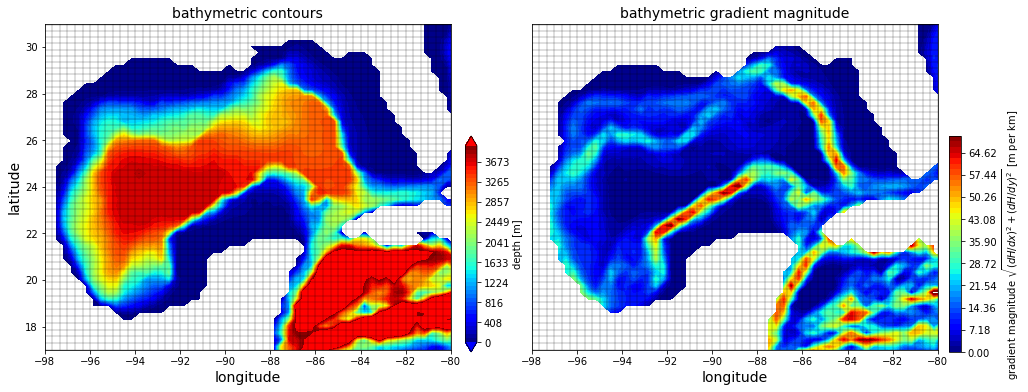

In [47]:
tile_to_plot = dep.isel(tile=tile_num)
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) != 0, np.nan)
f, (ax,ax2) = plt.subplots(1,2,figsize=(16,6))
colMap = plt.get_cmap('jet'); colMap.set_under(color='b'); colMap.set_over(color='r');
cc = ax.contourf(lons, lats, tile_to_plot, np.linspace(0,4000, 50,endpoint=True), cmap=colMap, vmin=0, vmax=4000, extend='both')
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.25)
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.25)
# ax.scatter(ecco_monthly_ds.XC.isel(tile=tile_num), ecco_monthly_ds.YC.isel(tile=tile_num), color='r', s=1)
# ax.scatter(ocx, ocy, s=1, color='r')
ax.set_title('bathymetric contours', fontsize=14)
ax.set_xlabel('longitude', fontsize=14); ax.set_ylabel('latitude', fontsize=14); 
ax.set_xlim(lon_range); ax.set_ylim(lat_range);
cbpos = [0.49, 0.12, 0.01, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label='depth [m]')

tile_to_plot = gradH
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) != 0, np.nan)
colMap = plt.get_cmap('jet'); colMap.set_under(color='b'); colMap.set_over(color='r');
cc = ax2.contourf(lons, lats, tile_to_plot, np.linspace(0,70, 40,endpoint=True), cmap=colMap, vmin=0, vmax=70)
ax2.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.25)
ax2.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.25)
# ax.scatter(ecco_monthly_ds.XC.isel(tile=tile_num), ecco_monthly_ds.YC.isel(tile=tile_num), color='r', s=1)
# ax2.scatter(ocx, ocy, s=1, color='r')
ax2.set_title('bathymetric gradient magnitude', fontsize=14)
ax2.set_xlabel('longitude', fontsize=14); ax2.set_yticks([]) 
ax2.set_xlim(lon_range); ax2.set_ylim(lat_range);
cbpos = [0.91, 0.12, 0.01, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label='gradient magnitude $\sqrt{(dH/dx)^2 + (dH/dy)^2}$ [m per km]')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_02_17/gom270_bathy_grad.jpg', dpi=250)

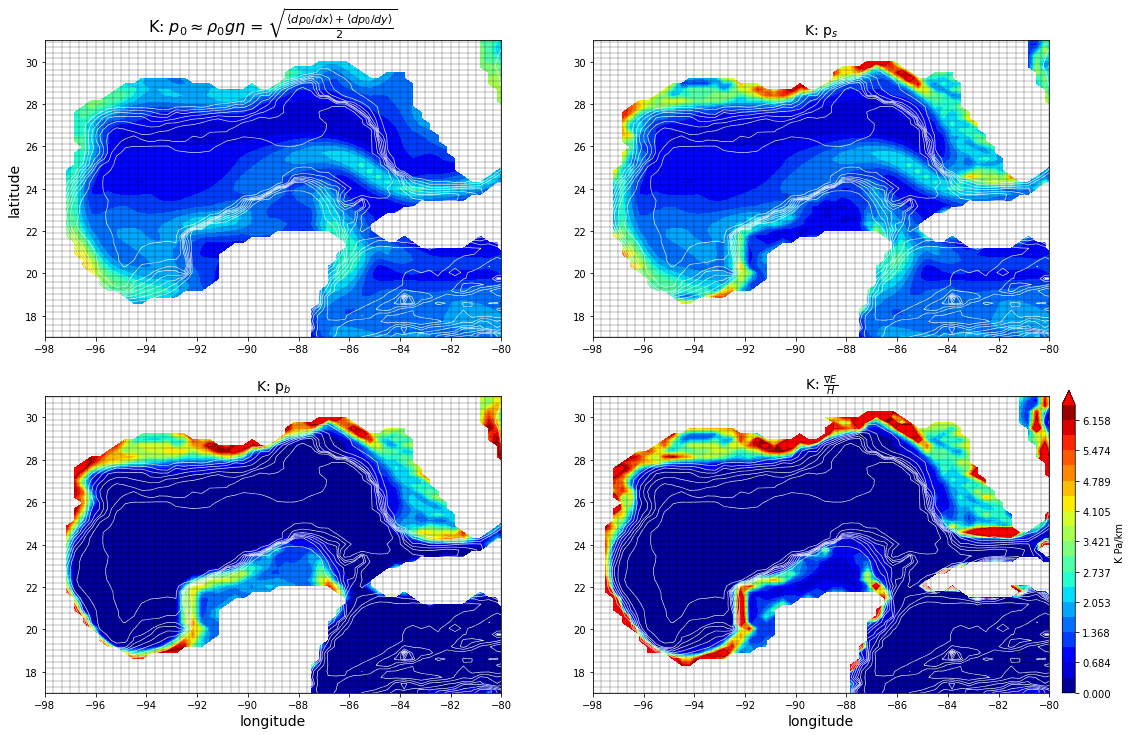

In [143]:
f, ax = plt.subplots(2,2,figsize=(18,12))
maxlim = 6.5
tile_to_plot = K_eta
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
Kc = ax[0,0].contourf(lons, lats, tile_to_plot, np.linspace(0, maxlim, 20,endpoint=True), cmap='jet', vmin=0, vmax=maxlim, extend='max')
# Kc = ax1.pcolor(lons, lats, tile_to_plot, cmap='jet', vmin=0, vmax=maxlim)
ax[0,0].contour(lons, lats, dep.isel(tile=tile_num), np.concatenate((np.arange(0,1750,250), np.arange(2000,6000,1000))), \
           linewidths=0.65, colors='w')
ax[0,0].plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.25)
ax[0,0].plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.25)
# ax1.scatter(ocx, ocy, s=4, color='r')
ax[0,0].set_title(r'K: $p_0 \approx \rho_0 g \eta$ = $\sqrt{ \frac{ \langle d p_0 /dx \rangle + \langle d p_0 /dy \rangle}{2}}$', fontsize=16)
ax[0,0].set_ylabel('latitude', fontsize=14);
ax[0,0].set_xlim(lon_range); ax[0,0].set_ylim(lat_range);

tile_to_plot = K_ster
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
Kc = ax[0,1].contourf(lons, lats, tile_to_plot, np.linspace(0, maxlim, 20,endpoint=True), cmap='jet', vmin=0, vmax=maxlim, extend='max')
# Kc = ax2.pcolor(lons, lats, tile_to_plot, cmap='jet', vmin=0, vmax=maxlim)
ax[0,1].contour(lons, lats, dep.isel(tile=tile_num), np.concatenate((np.arange(0,1750,250), np.arange(2000,6000,1000))), \
           linewidths=0.65, colors='w')
ax[0,1].plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.25)
ax[0,1].plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.25)
# ax2.scatter(ocx, ocy, s=4, color='r')
ax[0,1].set_title('K: p$_s$', fontsize=14); 
ax[0,1].set_xlim(lon_range); ax[0,1].set_ylim(lat_range);

tile_to_plot = K_obp
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
Kc = ax[1,0].contourf(lons, lats, tile_to_plot, np.linspace(0, maxlim, 20,endpoint=True), cmap='jet', vmin=0, vmax=maxlim, extend='max')
# Kc = ax2.pcolor(lons, lats, tile_to_plot, cmap='jet', vmin=0, vmax=maxlim)
ax[1,0].contour(lons, lats, dep.isel(tile=tile_num), np.concatenate((np.arange(0,1750,250),np.arange(2000,6000,1000))),linewidths=0.65,colors='w')
ax[1,0].plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.25)
ax[1,0].plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.25)
# ax2.scatter(ocx, ocy, s=4, color='r')
ax[1,0].set_title('K: p$_b$', fontsize=14); ax[1,0].set_xlabel('longitude', fontsize=14); ax[0,0].set_ylabel('latitude', fontsize=14);
ax[1,0].set_xlim(lon_range); ax[1,0].set_ylim(lat_range);

tile_to_plot = K_D
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
Kc = ax[1,1].contourf(lons, lats, tile_to_plot, np.linspace(0, maxlim, 20,endpoint=True), cmap='jet', vmin=0, vmax=maxlim, extend='max')
# Kc = ax2.pcolor(lons, lats, tile_to_plot, cmap='jet', vmin=0, vmax=maxlim)
ax[1,1].contour(lons, lats, dep.isel(tile=tile_num), np.concatenate((np.arange(0,1750,250),np.arange(2000,6000,1000))),linewidths=0.65,colors='w')
ax[1,1].plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.25)
ax[1,1].plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.25)
# ax2.scatter(ocx, ocy, s=4, color='r')
ax[1,1].set_title(r'K: $\frac{\nabla E}{H}$', fontsize=14); ax[1,1].set_xlabel('longitude', fontsize=14)
ax[1,1].set_xlim(lon_range); ax[1,1].set_ylim(lat_range);

cbpos = [0.91, 0.125, 0.01, 0.35]
cax = f.add_axes(cbpos)
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='K Pa/km')
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_02_17/K_270.jpg', dpi=250)

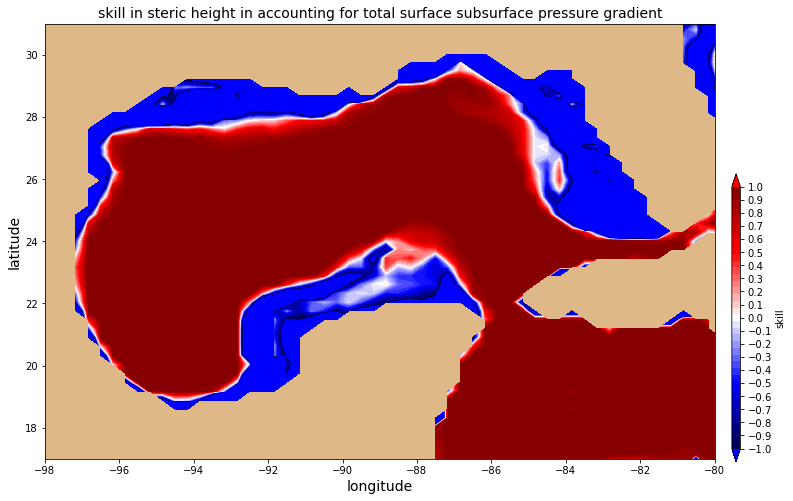

In [35]:
skill = 1 - (((deta_dx.isel(tile=tile_num) - dster_dx).var(dim='time') + \
             (deta_dy.isel(tile=tile_num) - dster_dy).var(dim='time')) / ((deta_dx.isel(tile=tile_num)).var(dim='time') + (deta_dy.isel(tile=tile_num)).var(dim='time')))
f, ax = plt.subplots(1,1,figsize=(12,8))
tile_to_plot = skill
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
colMap = plt.get_cmap('seismic'); colMap.set_under(color='b');
Kc = ax.contourf(lons, lats, tile_to_plot, np.linspace(-1, 1, 40,endpoint=True), cmap=colMap, vmin=-1, vmax=1, extend='both')
# ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.25)
# ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.25)
# ax.scatter(ocx, ocy, s=2, color='r')
ax.set_title('skill in steric height in accounting for total surface subsurface pressure gradient', fontsize=14)
ax.set_xlabel('longitude', fontsize=14)
ax.set_ylabel('latitude', fontsize=14)
ax.set_ylim(lat_range); ax.set_xlim(lon_range); # ax.set_xlim([-128,-40]); 
cbpos = [0.92, 0.12, 0.01, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='skill', ticks=np.arange(-1,1.1,0.1))
ax.set_facecolor('#DEB887');
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_02_04/K_270_eta_steric_skill.jpg', dpi=250)

In [20]:
K_eta_minus_ster = np.sqrt(0.5*((deta_dx.isel(tile=tile_num)-dster_dx.isel(tile=tile_num)).var(dim='time') + \
                                (deta_dy.isel(tile=tile_num)-dster_dy.isel(tile=tile_num)).var(dim='time')))
K_eta_minus_ster_minus_topo = np.sqrt(0.5*((deta_dx.isel(tile=tile_num) - dster_dx.isel(tile=tile_num) - topox).var(dim='time') + \
                                (deta_dy.isel(tile=tile_num) - dster_dy.isel(tile=tile_num) - topoy).var(dim='time')))
# skill = 1 - (((topox - (deta_dx.isel(tile=tile_num)-dster_dx.isel(tile=tile_num))).var(dim='time') + \
#              (topoy - (deta_dy.isel(tile=tile_num)-dster_dy.isel(tile=tile_num))).var(dim='time')) / ((topox).var(dim='time') + (topoy).var(dim='time')))

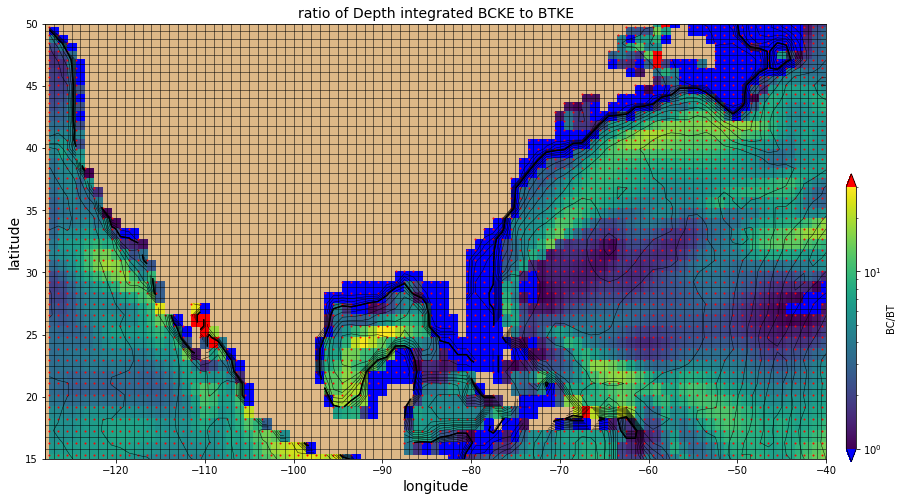

In [433]:
f, ax = plt.subplots(1,1,figsize=(14,8))
# tile_to_plot = 0.5*(u_da**2 + v_da**2).mean(dim='time')
tile_to_plot = KE_BC.mean(dim='time')/KE_BT.mean(dim='time')
# tile_to_plot = BC_BT_var
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
colMap = plt.get_cmap('viridis'); # colMap.set_under(color='b');colMap.set_over(color='r')
Kc = ax.pcolor(lons, lats, tile_to_plot, cmap=colMap, norm=LogNorm(vmin=1e0, vmax=3e1))
ax.contour(lons, lats, dep.isel(tile=tile_num), np.concatenate((np.arange(0,1000,200), np.arange(1000,6000,500))), \
           linewidths=0.45, colors='k')
ax.contour(lons, lats, dep.isel(tile=tile_num), [1000, 1001], linewidths=1.25, colors='k')
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.5)
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.5)
ax.set_title('ratio of Depth integrated BCKE to BTKE', fontsize=14)
ax.set_xlabel('longitude', fontsize=14)
ax.set_ylabel('latitude', fontsize=14)
ax.scatter(ocx, ocy, s=1, color='r')
ax.set_ylim(lat_range); ax.set_xlim([-128,-40]);
cbpos = [0.92, 0.12, 0.01, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='BC/BT')
ax.set_facecolor('#DEB887');
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_01_20/KE_BC_BT.jpg', dpi=250)

In [62]:
print(np.where((lons[:,0] > -95) & (lons[:,0] < -93))[0])
print(np.where((lats[0,:] > 25) & (lats[0,:] < 30))[0])

[106 107 108 109 110]
[213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230]


In [123]:
lats.isel(j=lon_test, i=lat_test)

<xarray.DataArray 'YC' ()>
array(59.485046, dtype=float32)
Coordinates:
    j        int64 31
    i        int64 74
    tile     int64 10
    XC       float32 -117.6
    YC       float32 59.49
    CS       float32 0.0
    SN       float32 0.0
    Depth    float32 0.0
    rA       float32 3.257e+08
Attributes:
    coordinate:  YC XC
    units:       degrees_north
    long_name:   latitude

-93.166664
28.146582


(15721.5, 17516.5)

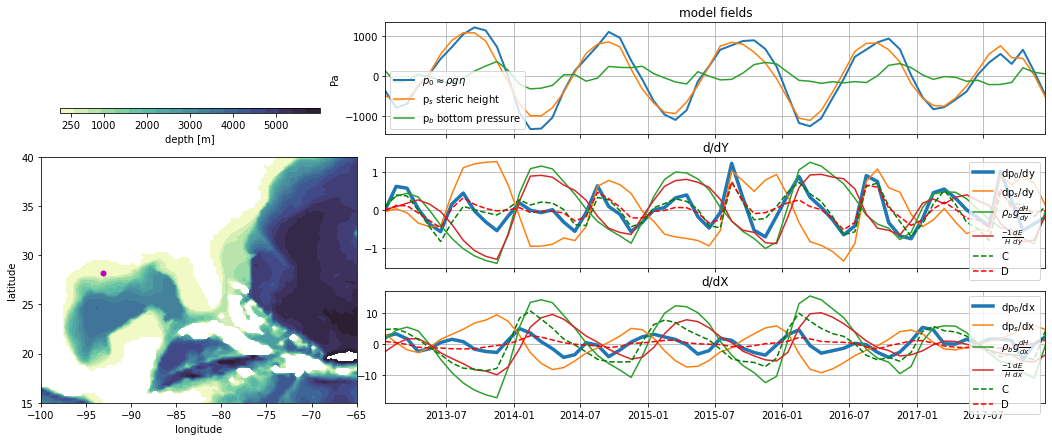

In [152]:
# -- LOC! -- 
# GOM basin / slope / slope 2
lon_test = 38
lat_test = 73  
# lon_test = 37 # 36,37,38
# lat_test = 71 # 69,70,71
lon_test = 31
lat_test = 74
# - Nova Scotia 
# lon_test = 74
# lat_test = 51
# - N Atl
# lon_test = 60
# lat_test = 73
# - w FL
# lon_test = 43
# lat_test = 73
# - YP
# lon_test = 43
# lat_test = 80
# -- LLC270 LOC!
this_lon = -93; this_lat = 28; 
pos_test = np.where((lons > (this_lon-0.175)) & (lons < (this_lon+0.175)) & (lats > (this_lat-0.175)) & (lats < (this_lat+0.175)))
lon_test = pos_test[0][0]; lat_test = pos_test[1][0];
print(lons[pos_test[0][0],pos_test[1][0]].data); print(lats[pos_test[0][0],pos_test[1][0]].data); 

f = plt.figure(figsize=(18, 7)); gs = gridspec.GridSpec(nrows=3, ncols=6, height_ratios=[1, 1, 1]);
ax0 = f.add_subplot(gs[1:, 0:2]); ax = f.add_subplot(gs[0, 2:]); 
ax2 = f.add_subplot(gs[1, 2:]); ax3 = f.add_subplot(gs[2, 2:]); 
# BATHYMETRY 
tile_to_plot = dep.isel(tile=tile_num); maxlim=6000 # K_eta; maxlim = 3
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
cc = ax0.contourf(lons, lats, tile_to_plot, np.linspace(0,maxlim,20,endpoint=True), cmap=cmocean.cm.deep, vmin=0, vmax=maxlim)
# ax0.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-',linewidth=0.25)
# ax0.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-',linewidth=0.25)
# ax0.scatter(ocx, ocy, s=2, color='r')
ax0.scatter(lons.isel(j=lon_test, i=lat_test), lats.isel(j=lon_test, i=lat_test), color='m', s=25)
ax0.set_xlabel('longitude'); ax0.set_ylabel('latitude');
ax0.set_xlim([-100, -65]); ax0.set_ylim([15, 40]); cbpos = [0.14, 0.7, 0.2, 0.01]; cax = f.add_axes(cbpos)
cb = f.colorbar(cc, cax=cax, orientation='horizontal', extend='both', label='depth [m]', ticks=[250, 1000, 2000, 3000, 4000, 5000])
cb.ax.set_xticklabels(['250', '1000','2000','3000','4000', '5000'])
# FIELDS 
ax.plot(ecco_monthly_ds.time,s_press.isel(tile=tile_num, j=lon_test, i=lat_test), label=r'$p_0 \approx \rho g \eta$', linewidth=2)
ax.plot(ecco_monthly_ds.time,ster.isel(j=lon_test, i=lat_test), label=r'p$_s$ steric height')
ax.plot(ecco_monthly_ds.time,obp.isel(tile=tile_num, j=lon_test, i=lat_test), label=r'p$_b$ bottom pressure')
# ax.plot(ecco_monthly_ds.time, \
#         ster.isel(tile=tile_num)[:, lon_test, lat_test] + obp.isel(tile=tile_num)[:, lon_test, lat_test], label=r'p$_s$ + p$_b$', color='k', linestyle='--')
ax.set_title('model fields'); ax.set_ylabel('Pa'); ax.legend(); ax.grid(); ax.set_xticklabels(['']); ax.set_xlim([ecco_monthly_ds.time[0], ecco_monthly_ds.time[-1]])
# DDY
ax2.plot(ecco_monthly_ds.time,deta_dy.isel(tile=tile_num, j=lon_test, i=lat_test), label=r'dp$_0$/dy', linewidth=3.5)
ax2.plot(ecco_monthly_ds.time,dster_dy.isel(j=lon_test, i=lat_test), label=r'dp$_s$/dy', linewidth=1.5)
ax2.plot(ecco_monthly_ds.time,topoy.isel(j=lon_test, i=lat_test), label=r'$\rho_b g \frac{dH}{dy}$', linewidth=1.5)
# ax2.plot(ecco_monthly_ds.time,a_D_y[lon_test, lat_test, :], label=r'dD/dy', linewidth=1.5)
ax2.plot(ecco_monthly_ds.time,dpb_dy.isel(j=lon_test, i=lat_test), label=r'$\frac{-1}{H}\frac{dE}{dy}$', linewidth=1.5)
approx_sum_y = dster_dy.isel(j=lon_test, i=lat_test) + topoy.isel(j=lon_test, i=lat_test) # + dpb_dy[lon_test, lat_test, :] # + hpg_dap_y[lon_test, lat_test, :]
ax2.plot(ecco_monthly_ds.time,approx_sum_y, color='g', linestyle='--', label='C')
ax2.plot(ecco_monthly_ds.time, dster_dy.isel(j=lon_test, i=lat_test) + dpb_dy.isel(j=lon_test, i=lat_test), color='r', linestyle='--', label='D')
# ax2.plot(ecco_monthly_ds.time,dahpg_y[lon_test, lat_test, :], label=r'dpavg/dy', linewidth=1.5)
# ax2.plot(ecco_monthly_ds.time,hpg_dap_y[lon_test, lat_test, :], label=r'dpavg/dy 2', linewidth=1.5)
test = np.ceil(ecco_grid.hFacC.isel(tile=tile_num).sum(dim='k')) - 1
# ax2.plot(ecco_monthly_ds.time,(rho_a_detrend.isel(layer=test.astype(int)))[:, lon_test, lat_test], label=r'bottom density', linewidth=1.5)
ax2.set_title('d/dY'); ax2.legend(); ax2.grid(); ax2.set_xticklabels(['']); ax2.set_xlim([ecco_monthly_ds.time[0], ecco_monthly_ds.time[-1]])
# DDX
ax3.plot(ecco_monthly_ds.time,deta_dx.isel(tile=tile_num, j=lon_test, i=lat_test), label=r'dp$_0$/dx', linewidth=3.5)
ax3.plot(ecco_monthly_ds.time,dster_dx.isel(j=lon_test, i=lat_test), label=r'dp$_s$/dx', linewidth=1.5)
ax3.plot(ecco_monthly_ds.time,topox.isel(j=lon_test, i=lat_test), label=r'$\rho_b g \frac{dH}{dx}$', linewidth=1.5)
# ax3.plot(ecco_monthly_ds.time,a_D_x[lon_test, lat_test, :], label=r'dD/dx', linewidth=1.5)
ax3.plot(ecco_monthly_ds.time,dpb_dx.isel(j=lon_test, i=lat_test), label=r'$\frac{-1}{H}\frac{dE}{dx}$', linewidth=1.5)
approx_sum_x = dster_dx.isel(j=lon_test, i=lat_test) + topox.isel(j=lon_test, i=lat_test) # + dpb_dx[lon_test, lat_test, :] # + hpg_dap_x[lon_test, lat_test, :]
ax3.plot(ecco_monthly_ds.time, approx_sum_x, color='g', linestyle='--', label='C')
ax3.plot(ecco_monthly_ds.time, dster_dx.isel(j=lon_test, i=lat_test) + dpb_dx.isel(j=lon_test, i=lat_test), color='r', linestyle='--', label='D')
# ax3.plot(ecco_monthly_ds.time,dahpg_x[lon_test, lat_test, :], label=r'dpavg/dx', linewidth=1.5)
# ax3.plot(ecco_monthly_ds.time,hpg_dap_x[lon_test, lat_test, :], label=r'dpavg/dx 2', linewidth=1.5)
ax3.set_title('d/dX'); ax3.legend(); ax3.grid(); ax3.set_xlim([ecco_monthly_ds.time[0], ecco_monthly_ds.time[-1]])
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_02_17/timeseries_3.jpg', dpi=250)

In [120]:
# topoy.isel(j=lat_test, i=lon_test)
this_lon = -90; this_lat = 25; 
pos_test = np.where((lons > (this_lon-0.175)) & (lons < (this_lon+0.175)) & (lats > (this_lat-0.175)) & (lats < (this_lat+0.175)))
print(lons[pos_test[0][0], pos_test[1][0]].data)
print(lats[pos_test[0][0], pos_test[1][0]].data)
# print(lats[pos_test[0],pos_test[1]].data)

-90.166664
25.133965


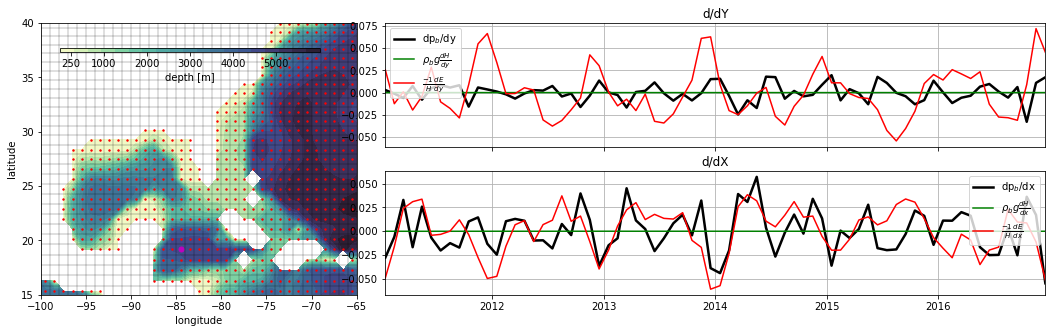

In [691]:
f = plt.figure(figsize=(18, 5))
gs = gridspec.GridSpec(nrows=2, ncols=6, height_ratios=[1, 1])
ax0 = f.add_subplot(gs[:, 0:2])
ax = f.add_subplot(gs[0, 2:])
ax2 = f.add_subplot(gs[1, 2:])
# BATHYMETRY 
tile_to_plot = dep.isel(tile=tile_num); maxlim=6000 # K_eta; maxlim = 3
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
cc = ax0.contourf(lons, lats, tile_to_plot, np.linspace(0,maxlim,20,endpoint=True), cmap=cmocean.cm.deep, vmin=0, vmax=maxlim)
ax0.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-',linewidth=0.25)
ax0.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-',linewidth=0.25)
ax0.scatter(ocx, ocy, s=2, color='r')
ax0.scatter(lons[lon_test,lat_test], lats[lon_test, lat_test], color='m', s=25)
ax0.set_xlabel('longitude'); ax0.set_ylabel('latitude');
ax0.set_xlim([-100, -65]); ax0.set_ylim([15, 40]);
cbpos = [0.14, 0.8, 0.2, 0.01]; cax = f.add_axes(cbpos)
cb = f.colorbar(cc, cax=cax, orientation='horizontal', extend='both', label='depth [m]', ticks=[250, 1000, 2000, 3000, 4000, 5000])
cb.ax.set_xticklabels(['250', '1000','2000','3000','4000', '5000'])

ax.plot(ecco_monthly_ds.time,dobp_dy.isel(tile=tile_num)[:,lon_test, lat_test], label=r'dp$_b$/dy', linewidth=2.5, color='k')
ax.plot(ecco_monthly_ds.time,topoy[:, lon_test, lat_test], label=r'$\rho_b g \frac{dH}{dy}$', linewidth=1.5, color='g')
ax.plot(ecco_monthly_ds.time,dpb_dy[lon_test, lat_test, :], label=r'$\frac{-1}{H}\frac{dE}{dy}$', linewidth=1.5, color='r')
# ax.plot(ecco_monthly_ds.time,a_D_y[lon_test, lat_test, :], label=r'dD/dy', linewidth=1.5)
# ax.plot(ecco_monthly_ds.time,dahpg_y[lon_test, lat_test, :], label=r'dpavg/dy', linewidth=1.5)
# ax.plot(ecco_monthly_ds.time,deta_dy.isel(tile=tile_num)[:, lon_test, lat_test] - \
#         dster_dy.isel(tile=tile_num)[:, lon_test, lat_test] - \
#         dpb_dy[lon_test, lat_test, :], color='k', linestyle='--')
# ax.plot(ecco_monthly_ds.time,hpg_dap_y[lon_test, lat_test, :], label=r'dpavg/dy 2', linewidth=1.5)
# ax.plot(ecco_monthly_ds.time, dpb_dy[lon_test, lat_test, :] + topoy[:, lon_test, lat_test], linestyle='--',  color='k')
# ax.plot(ecco_monthly_ds.time, hpg_dap_y[lon_test, lat_test,:] - dpb_dy[lon_test, lat_test, :], linestyle='--',  color='k')
ax.set_title('d/dY'); ax.legend(); ax.grid(); ax.set_xticklabels(['']); ax.set_xlim([ecco_monthly_ds.time[0], ecco_monthly_ds.time[-1]])

ax2.plot(ecco_monthly_ds.time,dobp_dx.isel(tile=tile_num)[:,lon_test, lat_test], label=r'dp$_b$/dx', linewidth=2.5, color='k')
ax2.plot(ecco_monthly_ds.time,topox[:, lon_test, lat_test], label=r'$\rho_b g \frac{dH}{dx}$', linewidth=1.5, color='g')
# ax2.plot(ecco_monthly_ds.time,a_D_x[lon_test, lat_test, :], label=r'dD/dx', linewidth=1.5)
ax2.plot(ecco_monthly_ds.time,dpb_dx[lon_test, lat_test, :], label=r'$\frac{-1}{H}\frac{dE}{dx}$', linewidth=1.5, color='r')
# ax2.plot(ecco_monthly_ds.time,dahpg_x[lon_test, lat_test, :], label=r'dpavg/dx', linewidth=1.5)
# ax2.plot(ecco_monthly_ds.time, hpg_dap_x[lon_test, lat_test, :], label=r'dpavg/dy 2', linewidth=1.5)
# ax2.plot(ecco_monthly_ds.time,topox[:, lon_test, lat_test] + dpb_dx[lon_test, lat_test, :], linestyle='--',  color='k')
# ax2.plot(ecco_monthly_ds.time, deta_dx.isel(tile=tile_num)[:, lon_test, lat_test] - \
#         dster_dx.isel(tile=tile_num)[:, lon_test, lat_test] - \
#         dpb_dx[lon_test, lat_test, :], color='k', linestyle='--')
ax2.set_title('d/dX'); ax2.legend(); ax2.grid(); ax2.set_xlim([ecco_monthly_ds.time[0], ecco_monthly_ds.time[-1]])
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_02_04/timeseries_obp_5.jpg', dpi=250)

In [135]:
np.shape(dster_dx)

(60, 270, 270)

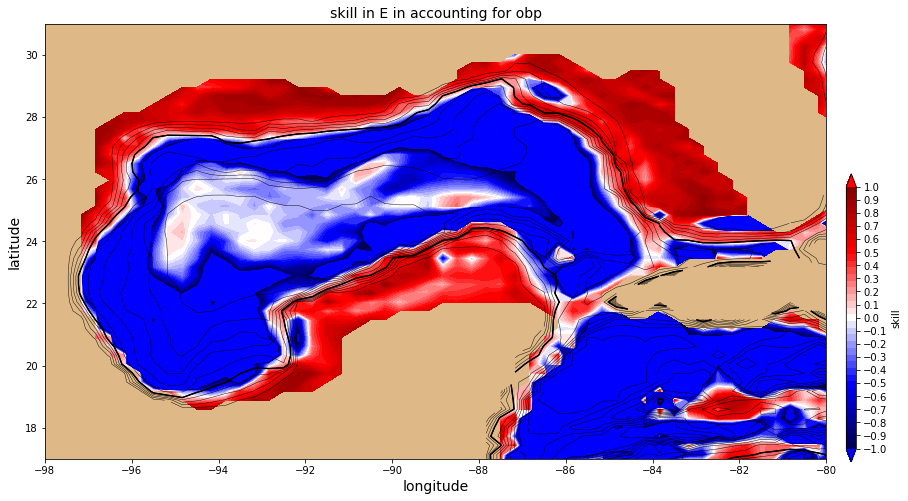

In [139]:
skill = 1 - ((dobp_dx.isel(tile=tile_num) - (dpb_dx)).var(dim='time') + \
             (dobp_dy.isel(tile=tile_num) - (dpb_dy)).var(dim='time')) / \
             ((dobp_dx.isel(tile=tile_num)).var(dim='time') + \
              (dobp_dy.isel(tile=tile_num)).var(dim='time'))
# skill = 1 - ((dobp_dy.isel(tile=tile_num) - (dpb_dy)).var(dim='time')) / \
#              ((dobp_dy.isel(tile=tile_num)).var(dim='time'))

f, ax = plt.subplots(1,1,figsize=(14,8))
tile_to_plot = skill
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
colMap = plt.get_cmap('seismic')
colMap.set_under(color='b');colMap.set_over(color='r')
Kc = ax.contourf(lons, lats, tile_to_plot, np.linspace(-1, 1, 40,endpoint=True), cmap=colMap, vmin=-1, vmax=1, extend='both')
# ax.contour(lons, lats, tile_to_plot, [0.1, 0.2, 0.3], colors='k', linewidths=0.5)
ax.contour(lons, lats, dep.isel(tile=tile_num), np.concatenate((np.arange(0,1000,200), np.arange(1000,6000,500))), \
           linewidths=0.45, colors='k')
ax.contour(lons, lats, dep.isel(tile=tile_num), [1000, 1001], linewidths=1.25, colors='k')
# ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.5)
# ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.5)
# ax.scatter(ocx, ocy, s=1, color='r')
ax.set_title('skill in E in accounting for obp', fontsize=14)
ax.set_xlabel('longitude', fontsize=14)
ax.set_ylabel('latitude', fontsize=14)
ax.set_ylim(lat_range); ax.set_xlim(lon_range); # ax.set_xlim([-128,-40]);
cbpos = [0.92, 0.12, 0.01, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='skill', ticks=np.arange(-1,1.1,0.1))
ax.set_facecolor('#DEB887');
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_02_17/K_270_skill_obp_E.jpg', dpi=250)

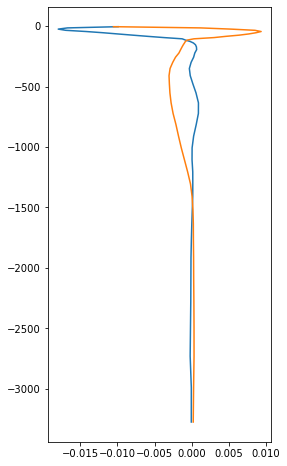

In [434]:
f, ax = plt.subplots(1,1,figsize=(4,8))
ax.plot(u1[0,:,lon_test,lat_test], zz[:,lon_test,lat_test])
ax.plot(v1[0,:,lon_test,lat_test], zz[:,lon_test,lat_test])

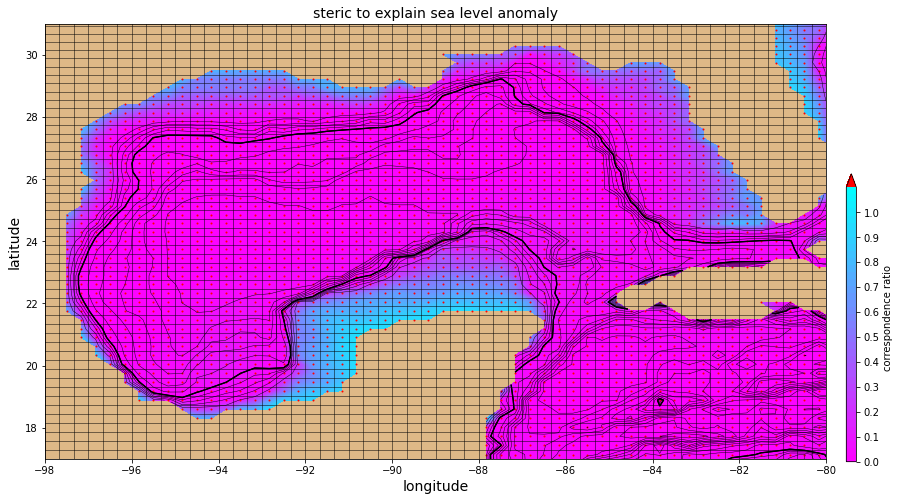

In [167]:
# skill2 = 1 - ((deta_dx.isel(tile=tile_num) - (dster_dx + dpb_dx)).var(dim='time') + \
#              (deta_dy.isel(tile=tile_num) - (dster_dy + dpb_dy)).var(dim='time')) / \
#              ((deta_dx.isel(tile=tile_num)).var(dim='time') + \
#               ((deta_dy.isel(tile=tile_num)).var(dim='time')))
skill2 = ((s_press.isel(tile=tile_num) - (ster)).var(dim='time')) / \
             ((s_press.isel(tile=tile_num)).var(dim='time'))

f, ax = plt.subplots(1,1,figsize=(14,8))
tile_to_plot = skill2 
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
colMap = plt.get_cmap('cool_r')
colMap.set_under(color='b');colMap.set_over(color='r')
Kc = ax.contourf(lons, lats, tile_to_plot, np.linspace(0, 1.1, 40, endpoint=True), cmap=colMap, vmin=0, vmax=1.1, extend='max')
# ax.contour(lons, lats, tile_to_plot, [0.1, 0.2, 0.3], colors='k', linewidths=0.5)
ax.contour(lons, lats, dep.isel(tile=tile_num), np.concatenate((np.arange(0,1000,200), np.arange(1000,6000,500))), \
           linewidths=0.45, colors='k')
ax.contour(lons, lats, dep.isel(tile=tile_num), [1000, 1001], linewidths=1.25, colors='k')
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.5)
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.5)
ax.set_title('steric to explain sea level anomaly', fontsize=14)
ax.set_xlabel('longitude', fontsize=14)
ax.set_ylabel('latitude', fontsize=14)
ax.scatter(ocx, ocy, s=1, color='r')
ax.set_ylim(lat_range); ax.set_xlim(lon_range); # ax.set_xlim([-128,-40]);
cbpos = [0.92, 0.12, 0.01, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='correspondence ratio', ticks=np.arange(-1,1.1,0.1))
ax.set_facecolor('#DEB887');
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_02_17/gom_R_eta_ster.jpg', dpi=250)

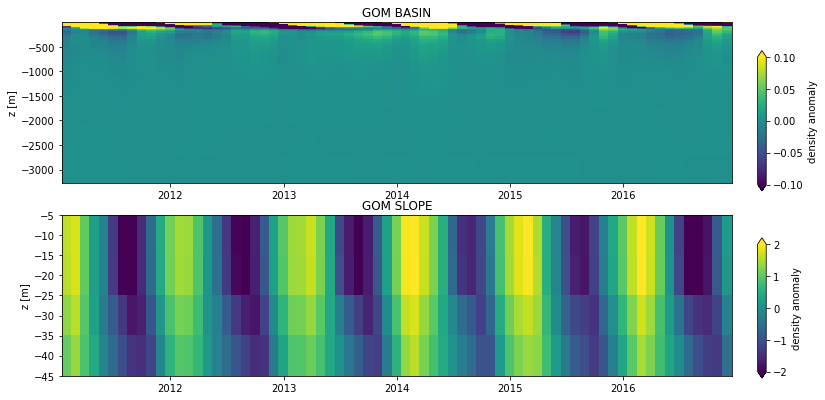

In [274]:
f, (ax,ax2) = plt.subplots(2,1,figsize=(12,6.5))
cc = ax.pcolor(ecco_monthly_ds.time, zz[:,lon_test, lat_test], np.transpose(rho_2[:, :, lon_test, lat_test].data), vmin=-.1, vmax=.1)
ax.set_ylim([np.nanmin(zz[:,lon_test, lat_test]), np.nanmax(zz[:,lon_test, lat_test])]); 
cbpos = [0.93, 0.52, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label='density anomaly'); ax.set_title('GOM BASIN'); ax.set_ylabel('z [m]')

cc = ax2.pcolor(ecco_monthly_ds.time, zz[:,lon_test_2, lat_test_2], np.transpose(rho_2[:, :, lon_test_2, lat_test_2].data), vmin=-2, vmax=2)
ax2.set_ylim([np.nanmin(zz[:,lon_test_2, lat_test_2]), np.nanmax(zz[:,lon_test_2, lat_test_2])]); 
cbpos = [0.93, 0.12, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label='density anomaly'); ax2.set_title('GOM SLOPE'); ax2.set_ylabel('z [m]')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_01_20/gom_timeseries_rho_column_2.jpg', dpi=250)

In [154]:
layer_thickness_2 = ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF
# layer_thickness_2 = layer_thickness_2.where(layer_thickness_2 != 0, np.nan)
zz_2 = layer_thickness_2.Z
zz_2 = zz_2.where(layer_thickness_2 != 0, np.nan)

rho_0 = ecco_monthly_ds.RHOAnoma.isel(tile=tile_num)
rho_0 = rho_0.where(ecco_monthly_ds.hFacC.isel(tile=tile_num) !=0, np.nan)
rho_a_2 = rho_0 - rho_0.mean(dim='time')
p_2 = rho_a_2.polyfit(dim='time', deg=1)
rho_a_2_trend = xr.polyval(rho_a_2['time'], p_2.polyfit_coefficients)
rho_a_2_detrend = rho_a_2 - rho_a_2_trend
rho_2 = rho_a_2_detrend
rho_2[0,:,lon_test_2,lat_test_2]

<xarray.DataArray (k: 50)>
array([1.61202319, 1.5930949 , 1.32353146, 1.05888233, 0.87892878,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan])
Coordinates:
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    j         int64 36
    i         int64 70
    tile      int64 10
    XC        float32 -91.5
    YC        float32 28.36
    CS        float32 -4.037e-15
    SN        float32 -1.0
    Z         (k) float32 -5.0 -15.0 -25.0 ... -5.039e+03 -5.461e+03 -5.906e+03
    Depth     float32 49.04
    rA        float32 9.612e+09
    PHrefC    (k) float32 49.05 147.1 245.2 ... 4.944e+04 5.357e+04 5.794e+04
    drF       (k) float32 10.0 10.0 10.0 10.0 10.0 ... 387.5 410.5 433.5 456.5
    hFacC     (k) float32 1.0 1.0 1.0 1.0 0.9045 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    maskC     (k) bool True True True True True ... False False False False
    timestep  int64 167292
    time      datetime64[ns] 2011-01-16T12:00:00

In [114]:
test = ecco_monthly_ds.SALT.isel(tile=tile_num)
test_face = ecco_monthly_ds.hFacC.isel(tile=tile_num)

test_face2 = test_face
test2 = test
test2 = test2.where(test_face2 != 0, np.nan)
# ecco_monthly_ds.RHOAnoma.isel(tile=tile_num)[0, :, lon_test_2, lat_test_2]
# test2[0,:,lon_test_2,lat_test_2]

# test_face2.isel(k=0)
# test2 = test2.where(test_face2.isel(k!=0) != 0, np.nan)
test2[0,:,lon_test_2,lat_test_2]

<xarray.DataArray 'SALT' (k: 50)>
array([36.017876, 36.007717, 36.001244, 35.997192, 35.990875,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan], dtype=float32)
Coordinates:
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    j         int64 36
    i         int64 70
    tile      int64 10
    XC        float32 -91.5
    YC        float32 28.36
    CS        float32 -4.037e-15
    SN        float32 -1.0
    Z         (k) float32 -5.0 -15.0 -25.0 ... -5.039e+03 -5.461e+03 -5.906e+03
    Depth     float32 49.04
    rA        float32 9.612e+09
    PHrefC    (k) float32 49.05 147.1 245.2 ... 4.944e+04 5.357e+04 5.794e+04
    drF       (k) float32 10.0 10.0 10.0 10.0 10.0 ... 387.5 410.5 433.5 456.5
    hFacC     (k) float32 1.0 1.0 1.0 1.0 0.9045 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    maskC     (k) bool True True True True True ... False False False False
    timestep  int64 167292
    time      datetime64[ns] 2011-01-16T12:00:00
Attributes:
    units:          psu
    long_name:      Salinity
    standard_name:  sea_water_salinity

In [ ]:
f, ax1 = plt.subplots(1,1,figsize=(8,6))
maxlim = 0.0004
tile_to_plot = K_obp
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
Kc = ax1.contourf(lons, lats, tile_to_plot, np.linspace(0, maxlim, 20,endpoint=True), cmap='jet', vmin=0, vmax=maxlim)
ax1.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.5)
ax1.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.5)
ax1.set_title('K eta')
ax1.set_xlabel('longitude')
ax1.set_ylabel('latitude')
ax1.set_xlim([-99, -70]); ax1.set_ylim([17, 36]);
cbpos = [0.94, 0.12, 0.01, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='K')